# Test notebook for scirpy usage
This notebook is the analog to the Colab created by Gregor S. for the demonstration of scirpy.datasets function usage:

https://colab.research.google.com/drive/15HIYGsSBHkDV399KSchv2QEyBzheL6fW?usp=sharing


1. The databases (McPAS, VDJDB and IEDB) are merged in a BioCypher Knowledge Graph (KG)
2. The Knowledge Graph is converted to a list of AIRR cells via BioCypher
3. The list of AIRR cells is converted to AnnData using scirpy functionality 

Note: in order to run this notebook, please pip install the forked BioCypher repository with AIRR conversion implementation

In [1]:
# %pip install "biocypher[scirpy] @ git+https://github.com/vd-dragan21/biocypher.git@add_anndata_kg"
# %pip install -e /home/lera/test/biocypher

In [2]:
import sys
sys.path.append('..')

import muon as mu
import numpy as np
import scanpy as sc

import scirpy as ir
from biocypher import BioCypher
from datetime import datetime
from scirpy.io._convert_anndata import from_airr_cells
from scirpy.pp import index_chains
from tcr_epitope.adapters.iedb_adapter import IEDBAdapter
from tcr_epitope.adapters.mcpas_adapter import MCPASAdapter
from tcr_epitope.adapters.vdjdb_adapter import VDJDBAdapter
# from tcr_epitope.adapters.utils import AnnDataKG
# from biocypher.output.in_memory._airr_to_anndata import AIRRtoAnnDataKG as AnnDataKG

sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)

/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO -- This is BioCypher v0.9.5.
INFO -- Logging into `biocypher-log/biocypher-20250513-192518.log`.


# Database merge into AnnData object

In [3]:
# Biocypher instance collect tuples generated from each
# Could be a function from_biocypher() or basically the way we create the graph

bc = BioCypher(cache_directory="../cache", biocypher_config_path="../config/biocypher_config.yaml",
    schema_config_path="../config/schema_config.yaml")
adapters = [
    VDJDBAdapter(bc, test = True),
    MCPASAdapter(bc, test = True),
    IEDBAdapter(bc, test = True),
]
for adapter in adapters:
    bc.add(adapter.get_nodes())
    bc.add(adapter.get_edges())

airr_cells = bc.get_kg()
adata = from_airr_cells(airr_cells)
index_chains(adata)
adata.uns["DB"] = {"name": "Biocypher", "date_downloaded": datetime.now().isoformat()}
print(adata)

INFO -- Running BioCypher with schema configuration from ../config/schema_config.yaml.
INFO -- Loading cache file ../cache/cache.json.
INFO -- Use cached version from ../cache/vdjdb_latest.
INFO -- Use cached version from ../cache/iedb_exact_matches_b28821a867027cba1b1a7712f25b2997.
INFO -- Use cached version from ../cache/iedb_exact_matches_330fd474668e348901c4b62bece36056.
INFO -- Use cached version from ../cache/iedb_substring_matchesa89c602ac7decc53bd3902bed715f4ae.
INFO -- Use cached version from ../cache/mcpas_latest.


Mapping AA epitope sequences to IEDB IDs: exact matches...
Processing batch 1/2
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(KLGGALQAK,NLVPMVATV,AVFDRKSDAK,RAKFKQL...
Processing batch 2/2
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(RTATKQYNV,FLNRFTTTL,LMNVLTLVY,IMDQVPFS...
Found 154 exact IEDB ID matches. Trying substring matches for {len(unmatched_epitopes)} remaining epitopes...
Final results: 167 of 173 epitopes matched to IEDB IDs (96.5%)


/home/lera/tcr-epitope/notebooks/../tcr_epitope/adapters/mcpas_adapter.py:40: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  table = pd.read_csv(table_path, encoding="utf-8-sig")
INFO -- Use cached version from ../cache/iedb_exact_matches_4cae0b8bf0545aafb3ef35ed1d2dbf36.
INFO -- Use cached version from ../cache/iedb_substring_matches064ce5c8acbd6a0b09ae3911239e8761.
INFO -- Use cached version from ../cache/iedb_latest.


Mapping AA epitope sequences to IEDB IDs: exact matches...
Processing batch 1/1
Request URL: https://query-api.iedb.org/epitope_search?linear_sequence=in.(GILGFVFTL,GLCTLVAML,TPRVTGGGAM,LPRRSGA...
Found 51 exact IEDB ID matches. Trying substring matches for {len(unmatched_epitopes)} remaining epitopes...
Final results: 54 of 56 epitopes matched to IEDB IDs (96.4%)


/home/lera/tcr-epitope/notebooks/../tcr_epitope/adapters/iedb_adapter.py:57: DtypeWarning: Columns (2,10,12,13,14,15,16,17,18,19,20,21,22,23,24,29,30,35,36,41,42,43,44,45,46,47,48,49,50,51,52,53,58,59,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  tcr_table = pd.read_csv(tcr_table_path, header=[0, 1])
/home/lera/tcr-epitope/notebooks/../tcr_epitope/adapters/iedb_adapter.py:62: DtypeWarning: Columns (14,18,43) have mixed types. Specify dtype option on import or set low_memory=False.
  bcr_table = pd.read_csv(bcr_table_path, header=[0, 1])
INFO -- Loading ontologies...
INFO -- Instantiating OntologyAdapter class for https://github.com/biolink/biolink-model/raw/v3.2.1/biolink-model.owl.ttl.
WARNING -- Duplicate node type tra sequence found. 
WARNING -- Duplicate node type trb sequence found. 
WARNING -- Duplicate node type epitope found. 
WARNING -- Duplicate edge type t cell receptor sequence to epitope association found. 
WARNING -- Duplicate edge typ

Filtering chains...
Indexing VJ chains...


/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/anndata/utils.py:354: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Indexing VDJ chains...
build result array
AnnData object with n_obs × n_vars = 3550 × 0
    obs: 'IEDB_ID', 'MHC_class', 'MHC_gene_1', 'MHC_gene_2', 'antigen_name', 'antigen_organism', 'data_source', 'is_paired', 'protein'
    uns: 'scirpy_version', 'chain_indices', 'DB'
    obsm: 'airr', 'chain_indices'


# Data import and preprocessing

In [4]:
mdata = ir.datasets.wu2020_3k()
ir.pp.index_chains(mdata)
ir.tl.chain_qc(mdata)
mu.pp.filter_obs(mdata, "airr:chain_pairing", lambda x: ~np.isin(x, ["orphan VDJ", "orphan VJ", "multichain"]))

Filtering chains...
Indexing VJ chains...


/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


Indexing VDJ chains...
build result array
Stored result in `mdata.obs["airr:receptor_type"]`.
Stored result in `mdata.obs["airr:receptor_subtype"]`.
Stored result in `mdata.obs["airr:chain_pairing"]`.


# Clonotype clustering

Computing sequence x sequence distance matrix for VJ sequences.
block size set to 50


100%|██████████| 496/496 [00:11<00:00, 44.34it/s] 

Computing sequence x sequence distance matrix for VDJ sequences.
block size set to 50



100%|██████████| 496/496 [00:05<00:00, 96.39it/s] 

Initializing lookup tables. 


Computing clonotype x clonotype distances.
Stored result in `mdata.obs["airr:cc_aa_alignment"]`.
Stored result in `mdata.obs["airr:cc_aa_alignment_size"]`.


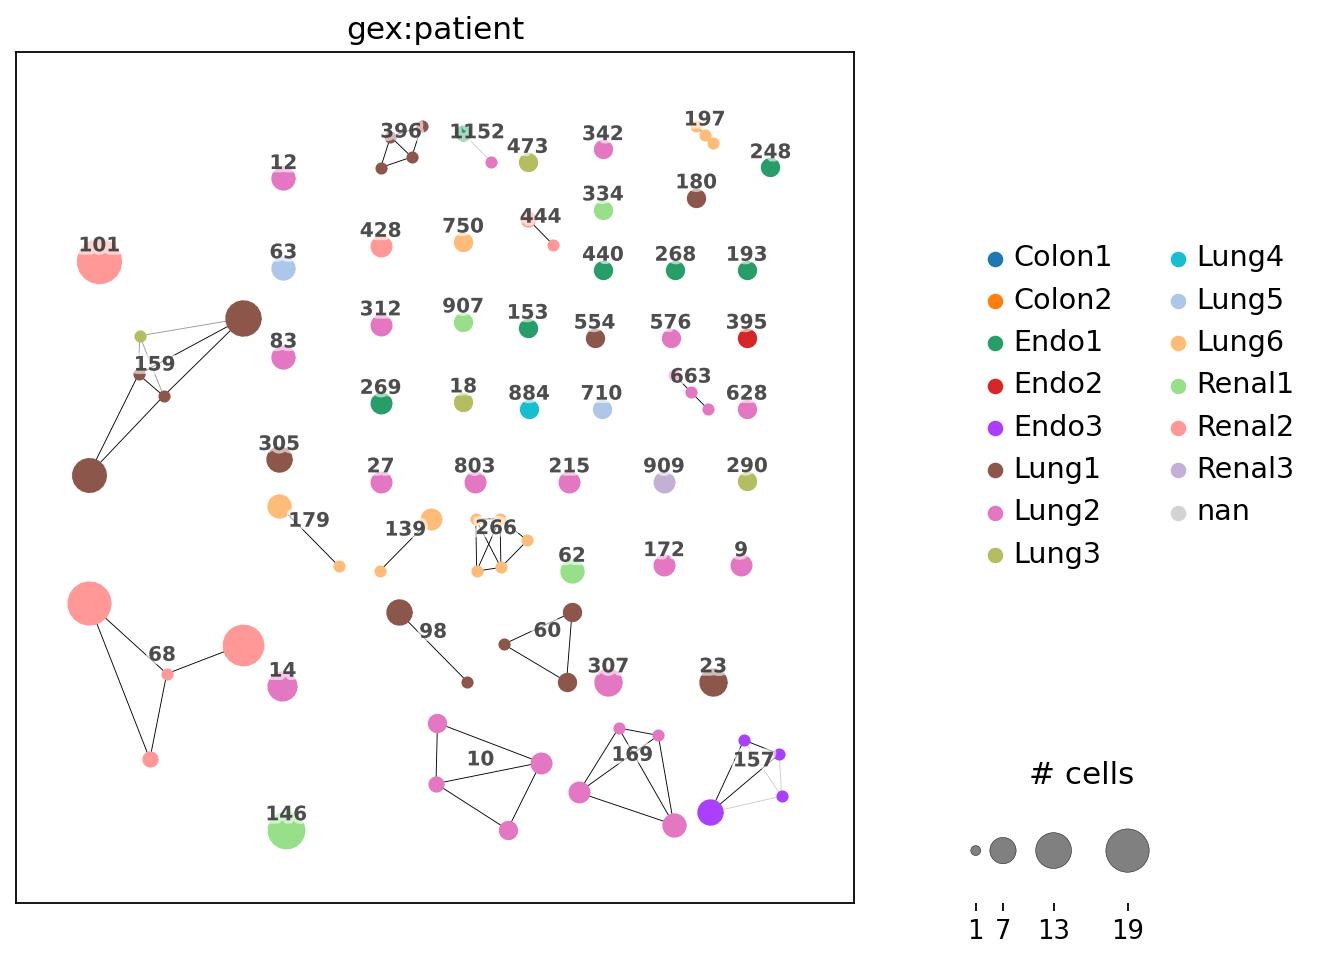

In [5]:
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa",
    cutoff=15)

ir.tl.define_clonotype_clusters(mdata,
                                sequence="aa",
                                metric="alignment",
                                receptor_arms="all",
                                dual_ir="any")

#min_cells = 3 will only plot clonotype clusters with a size >= 3
ir.tl.clonotype_network(mdata, min_cells=3, sequence="aa", metric="alignment")

_ = ir.pl.clonotype_network(mdata, color="gex:patient", label_fontsize=9, panel_size=(7, 7), base_size=20)

# save figure as a png
#plt.savefig("clonotype_network.png", bbox_inches="tight")

In [6]:
ir.get.airr(adata, airr_variable = ["v_call","j_call", "junction_aa"], chain = ["VDJ_1"]).head(5)

,VDJ_1_v_call,VDJ_1_j_call,VDJ_1_junction_aa
cell_id,,,
tra:CAVDNNNDMRF-trb:CASSPRGDSGNTIYF,TRBV18,TRBJ1-3,CASSPRGDSGNTIYF
tra:CAGSRGGSQGNLIF-trb:CSVEGASGRGDTQYF,TRBV29-1,TRBJ2-3,CSVEGASGRGDTQYF
tra:CALSGNTPLVF-trb:CASSYSGSGADTQYF,TRBV6-2,TRBJ1-93,CASSYSGSGADTQYF
tra:CAVRDGDYKLSF-trb:CASSYSGSGADTQYF,TRBV6-2,TRBJ1-93,CASSYSGSGADTQYF
tra:CAASEGGFKTIF-trb:CASSLGTGHNEQFF,TRBV11-2,None,CASSLGTGHNEQFF


Index(['IEDB_ID', 'MHC_class', 'MHC_gene_1', 'MHC_gene_2', 'antigen_name',
       'antigen_organism', 'data_source', 'is_paired', 'protein',
       'VDJ_1_j_call'],
      dtype='object')


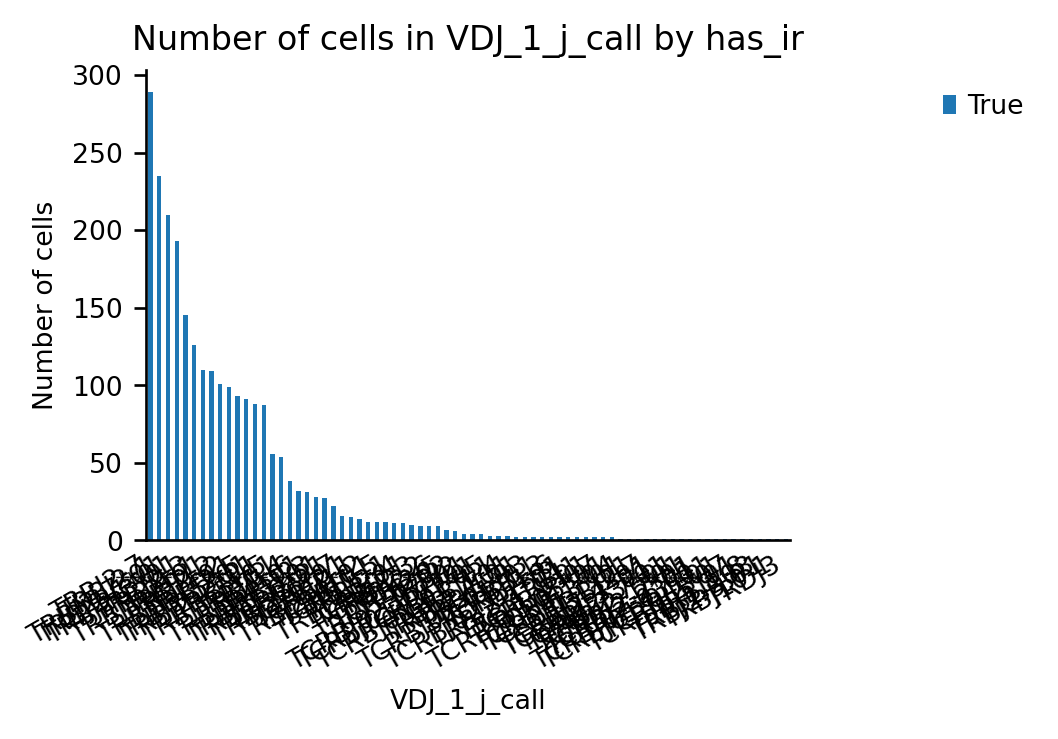

In [7]:
with ir.get.airr_context(adata, "j_call", "VDJ_1"):
    print(adata.obs.columns)
    _= ir.pl.group_abundance(adata, groupby="VDJ_1_j_call", max_cols = 0)
    # plt.xticks(rotation=50, ha='right')

In [8]:
ir.pp.ir_dist(mdata, adata, metric="fastalignment", sequence="aa", cutoff = 10)

Computing sequence x sequence distance matrix for VJ sequences.
block size set to 50


100%|██████████| 775/775 [00:01<00:00, 456.86it/s]

Computing sequence x sequence distance matrix for VDJ sequences.
block size set to 65



100%|██████████| 1008/1008 [00:03<00:00, 304.82it/s]


In [9]:
ir.tl.ir_query(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    receptor_arms="VDJ",
    dual_ir="primary_only",
)

Initializing lookup tables. 
Computing clonotype x clonotype distances.
Stored IR distance matrix in `adata.uns["ir_query_Biocypher_aa_fastalignment"]`.


In [10]:
ir.tl.ir_query_annotate(
    mdata,
    adata,
    metric="fastalignment",
    sequence="aa",
    strategy = "most-frequent",
    include_ref_cols=["antigen_name"],
)

  0%|          | 0/242 [00:00<?, ?it/s]/home/lera/.cache/pypoetry/virtualenvs/tcr-epitope-cBadFBpD-py3.11/lib/python3.11/site-packages/scirpy/tl/_ir_query.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return values[0]
100%|██████████| 242/242 [00:00<00:00, 1093.29it/s]

Stored result in `mdata.obs["airr:antigen_name"]`.


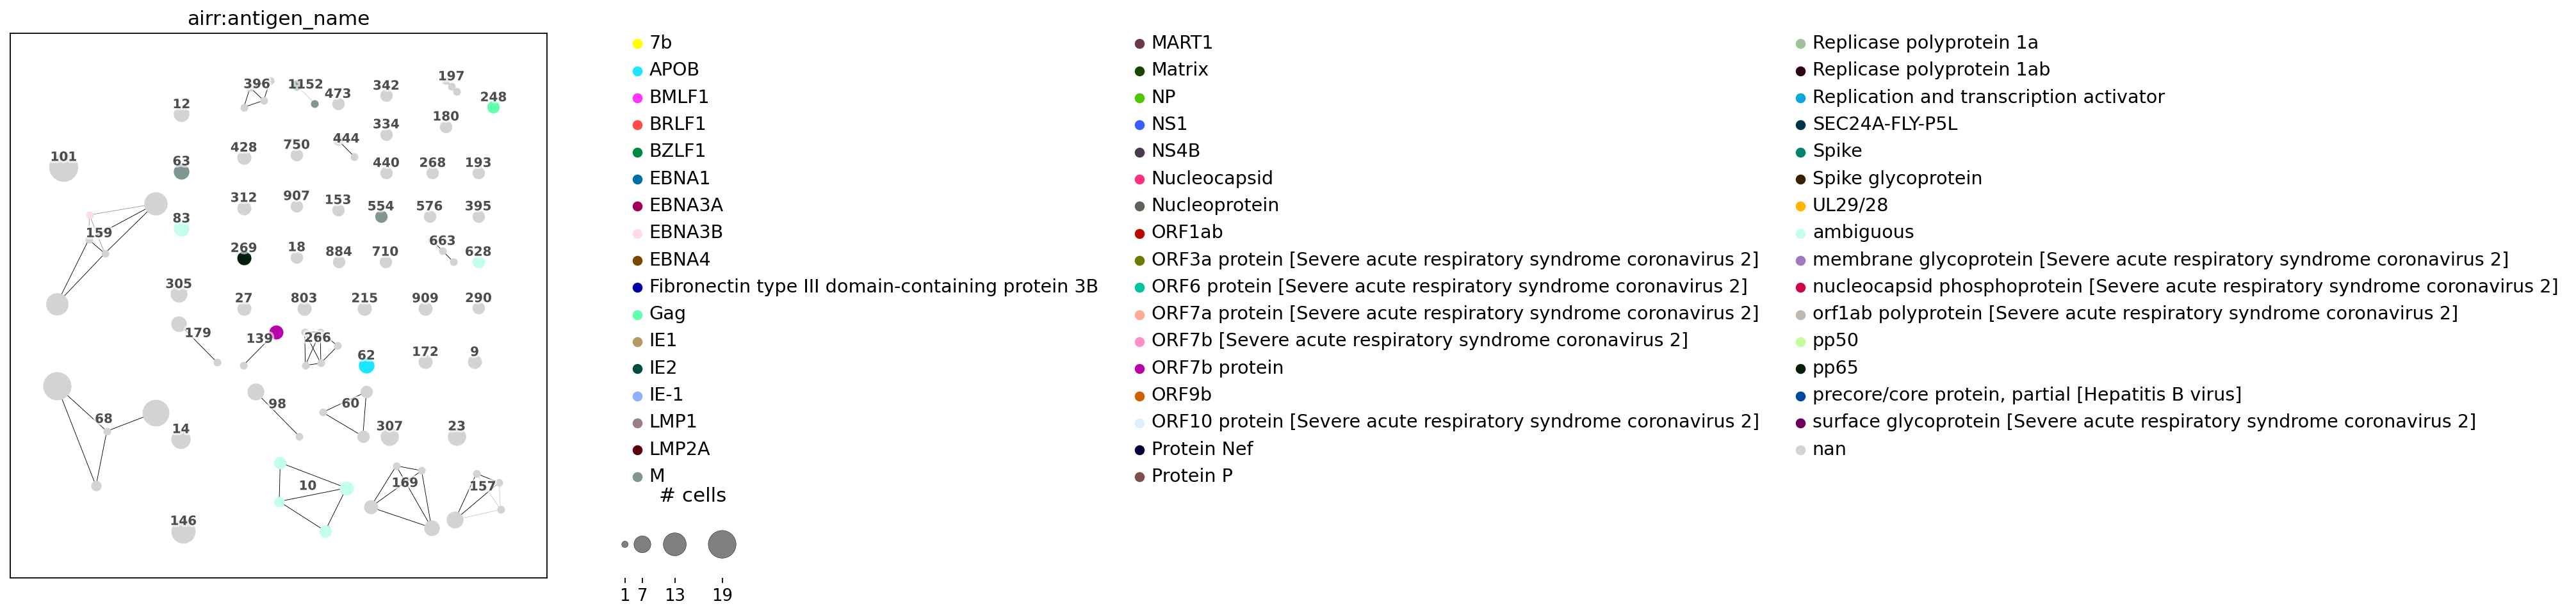

In [11]:
_=ir.pl.clonotype_network(mdata, color="airr:antigen_name", label_fontsize=9, panel_size=(7, 7), base_size=20)